In [25]:
from utils import *

In [26]:
results_path = 'results/'
result_files = os.listdir(results_path)
print(result_files)

['bert-base-uncased_toxic_classification_FGSM_results.pkl']


In [27]:
# load pickled results
results = []
for result_file in result_files:
    with open(results_path + result_file, 'rb') as f:
        results.append(pickle.load(f))

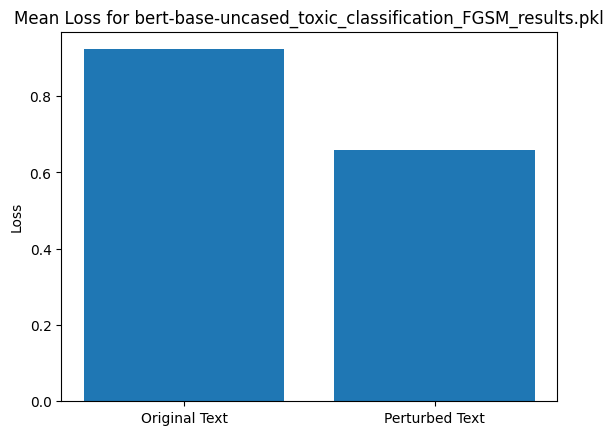

Original Accuracy: 0.5734382824236355
Perturbed Accuracy: 0.6873122183274912
Original Recall: 0.981429745275267
Perturbed Recall: 0.9503697617091208


In [28]:
for result, result_file in zip(results, result_files):
    result_raw_metrics = [result[r] for r in result]
    mean_original_text_loss = np.mean([r['original_text_loss'] for r in result_raw_metrics])
    mean_perturbed_text_loss = np.mean([r['perturbed_text_loss'] for r in result_raw_metrics]) # change to perturbed_text_loss

    # bar plot
    fig, ax = plt.subplots()
    ax.bar(['Original Text', 'Perturbed Text'], [mean_original_text_loss, mean_perturbed_text_loss])
    ax.set_ylabel('Loss')
    ax.set_title('Mean Loss for ' + result_file)
    plt.show()

    true_labels = [r['true_label'] for r in result_raw_metrics]
    thresh = 0.5
    original_pred_labels = [r['original_text_pred'] > thresh for r in result_raw_metrics]
    perturbed_pred_labels = [r['perturbed_text_pred'] > thresh for r in result_raw_metrics]

    # imports
    # accuracy
    original_accuracy = accuracy_score(true_labels, original_pred_labels)
    perturbed_accuracy = accuracy_score(true_labels, perturbed_pred_labels)

    # recall
    original_recall = recall_score(true_labels, original_pred_labels)
    perturbed_recall = recall_score(true_labels, perturbed_pred_labels)

    print('Original Accuracy:', original_accuracy)
    print('Perturbed Accuracy:', perturbed_accuracy)
    print('Original Recall:', original_recall)
    print('Perturbed Recall:', perturbed_recall)

# Visualize Embeddings

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_model = 'bert-base-uncased'
model = AutoModel.from_pretrained(transformer_model, weights_only=True).to(device)
tokenizer = AutoTokenizer.from_pretrained(transformer_model)

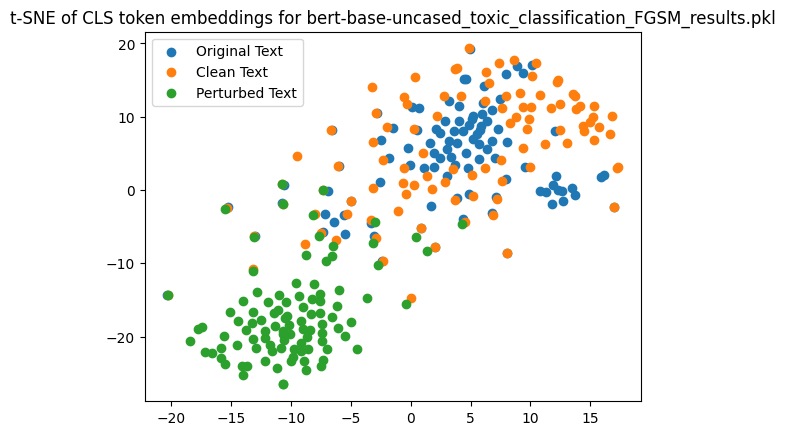

In [30]:
for result, result_file in zip(results, result_files):
    all_original_text = [r for r in result]
    all_perturbed_text = [result[r]['perturbed_text'] for r in result]
    num_samples = 100
    # sample 100 random samples
    random_indices = np.random.choice(len(all_original_text), num_samples, replace=False)

    original_text_samples = [all_original_text[i] for i in random_indices]
    suffix_size = 20
    clean_text_samples = [original[:-suffix_size] for original in original_text_samples]
    perturbed_text_samples = [all_perturbed_text[i] for i in random_indices]

    # get embeddings of CLS token
    original_cls_embeddings = []
    clean_cls_embeddings = []
    perturbed_cls_embeddings = []
    for original_text, clean_text, perturbed_text in zip(original_text_samples, clean_text_samples, perturbed_text_samples):
        original_cls_embeddings.append(get_cls_token_embedding(original_text, model, tokenizer, device))
        clean_cls_embeddings.append(get_cls_token_embedding(clean_text, model, tokenizer, device))
        perturbed_cls_embeddings.append(get_cls_token_embedding(perturbed_text, model, tokenizer, device))

    # Move the tensors to the CPU and convert them to numpy arrays
    original_cls_embeddings = np.array([embedding.cpu().detach().numpy().squeeze() for embedding in original_cls_embeddings])
    clean_cls_embeddings = np.array([embedding.cpu().detach().numpy().squeeze() for embedding in clean_cls_embeddings])
    perturbed_cls_embeddings = np.array([embedding.cpu().detach().numpy().squeeze() for embedding in perturbed_cls_embeddings])

    # Concatenate original and perturbed embeddings
    all_cls_embeddings = np.concatenate((original_cls_embeddings, clean_cls_embeddings, perturbed_cls_embeddings))

    # Initialize t-SNE
    tsne = TSNE(n_components=2, random_state=0)

    # Perform t-SNE transformation
    all_cls_embeddings_tsne = tsne.fit_transform(all_cls_embeddings)

    # Split the embeddings back into original and perturbed
    original_cls_embeddings_tsne = all_cls_embeddings_tsne[:num_samples]
    clean_cls_embeddings_tsne = all_cls_embeddings_tsne[num_samples:2*num_samples]
    perturbed_cls_embeddings_tsne = all_cls_embeddings_tsne[2*num_samples:]

    # plot
    fig, ax = plt.subplots()
    ax.scatter(original_cls_embeddings_tsne[:, 0], original_cls_embeddings_tsne[:, 1], label='Original Text')
    ax.scatter(clean_cls_embeddings_tsne[:, 0], clean_cls_embeddings_tsne[:, 1], label='Clean Text')
    ax.scatter(perturbed_cls_embeddings_tsne[:, 0], perturbed_cls_embeddings_tsne[:, 1], label='Perturbed Text')
    ax.legend()
    ax.set_title('t-SNE of CLS token embeddings for ' + result_file)
    plt.show()